# 2 st Assignment: Mixed-Integer Linear Programming

Generate random data, consider n=500 observations (i=1,…,500), from a predefined linear regression model with m=20 variables (j=1,…,20). Assume that the regression coefficients are integers so that −5 ≤ 𝛽 𝑗 ≤ 5. Assume also independent normal residuals.

$$ Y = \beta ' X + \epsilon $$

In [64]:
# Imports

import numpy as np
import pandas as pd
from sklearn.datasets import make_regression

from __future__ import division
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory


In [65]:
# Create random dataset 
i, j = 500, 20
reg = make_regression(i, j, coef=True)
Y = reg[1].reshape(i, 1)
X = np.column_stack((np.ones(i), np.asmatrix(reg[0])))
np.round(reg[2], 3)

array([  0.   ,  90.726,  23.464,   0.   ,  43.701,  48.632,  68.706,
        93.133,   0.   ,   0.   ,   0.   ,   0.   ,  52.192,   5.746,
         0.   ,   0.   ,   0.   ,  74.631,  91.515,   0.   ])

## Exercise 1

The classical least squares approach is to find the values of vector 𝛽 = (𝛽 1 , … , 𝛽 𝑗 , … , 𝛽 𝑚 ) 𝑇 so that:

$$ \min_{\beta} \sum^n_{i=1} (y_i - \beta ' x_i)^2 $$
    
where $x_i = (x_{1i} , … , x_{2i} , … , x_{mi} )$ 𝑇 for $ i = 1, ...,n.$

Estimate the value of the regression coefficients by using the analytical solution for the least squares estimation problem. Tip:

$$\beta_{ls} = (X^T X)^{-1}X^TY $$

In [66]:
# Calculate Beta normal equation
beta = np.linalg.inv(np.transpose(X)*X)*np.transpose(X)*Y
np.round(beta, 3)

array([[  0.   ],
       [ -0.   ],
       [ 90.726],
       [ 23.464],
       [  0.   ],
       [ 43.701],
       [ 48.632],
       [ 68.706],
       [ 93.133],
       [  0.   ],
       [ -0.   ],
       [ -0.   ],
       [ -0.   ],
       [ 52.192],
       [  5.746],
       [  0.   ],
       [  0.   ],
       [ -0.   ],
       [ 74.631],
       [ 91.515],
       [  0.   ]])

## Exercise 2

As an alternative, the least absolute value approach seeks to find the values of β by solving the following problem:

$$ \min_{\beta} \sum^n_{i=1} |y_i - \beta ' x_i| $$

Propose and implement in Pyomo an equivalent linear formulation for this problem. Compare the resulting β coefficients with the ones obtained in exercise 1).

$$ \min_{t,\beta}\sum^n_{i=1} t_i $$
$$s.t. \, -t \leq y-X\beta \leq t$$
$$t \geq 0 $$

In [91]:
nsample = 500
nvariables = 20
X0=np.ones([nsample, 1])
X1=np.random.uniform(0, 10, ([nsample,nvariables]))
X=np.concatenate([X0, X1], axis=1)
error=np.random.normal(0, 1, (nsample,1))
beta=np.random.uniform(-5, 5, size=([nvariables+1, 1]))
Y=np.dot(X, beta)+error
print(beta)

[[ 2.24435356]
 [ 2.97022968]
 [-2.06991866]
 [-2.78567529]
 [ 3.80243033]
 [ 3.19370519]
 [ 3.2699908 ]
 [ 0.18945074]
 [ 2.52183691]
 [ 4.06071894]
 [-2.18630334]
 [-2.7764884 ]
 [ 2.46165807]
 [ 3.75525518]
 [ 2.74022524]
 [ 4.63712124]
 [-4.98571654]
 [ 1.54036128]
 [ 3.42839076]
 [ 0.03983416]
 [-1.42143294]]


In [100]:
model = AbstractModel()


model.I = RangeSet(1, nsample)
model.J = RangeSet(1, nvariables+1)

model.B = Var(model.J, domain=Reals)

model.t = Var(model.I, domain=NonNegativeReals)


def obj_func(model):
    return sum(model.t[i] for i in model.I)
model.OBJ = Objective(rule=obj_func, sense=minimize)

def const1(model, i):
    return -(sum((model.B[j]*X[i-j, j-1]) for j in model.J)) - model.t[i] <= -Y[i-1]
model.const1 = Constraint(model.I, rule=const1)

def const2(model, i):
    return -(sum((model.B[j]*X[i-1, j-1]) for j in model.J)) + model.t[i] >= -Y[i-1]
model.const2 = Constraint(model.I, rule=const2)

def const3(model, i):
    return model.t[i] >= 0
model.const3 = Constraint(model.I, rule=const3)


In [101]:
instance = model.create_instance()
results = opt.solve(instance)
print(results)



Problem: 
- Lower bound: 11265.37438
  Upper bound: 11265.37438
  Number of objectives: 1
  Number of constraints: 1501
  Number of variables: 522
  Number of nonzeros: 22501
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Error rc: 0
  Time: 0.32839512825
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [102]:
model.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=0, Domain=None, Ordered=True, Bounds=None
        Not constructed
    J : Dim=0, Dimen=1, Size=0, Domain=None, Ordered=True, Bounds=None
        Not constructed

2 Var Declarations
    B : Size=0, Index=J
        Not constructed
    t : Size=0, Index=I
        Not constructed

1 Objective Declarations
    OBJ : Size=0, Index=None, Active=True
        Not constructed

3 Constraint Declarations
    const1 : Size=0, Index=I, Active=True
        Not constructed
    const2 : Size=0, Index=I, Active=True
        Not constructed
    const3 : Size=0, Index=I, Active=True
        Not constructed

8 Declarations: I J B t OBJ const1 const2 const3


In [103]:
instance.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=500, Domain=Integers, Ordered=True, Bounds=(1, 500)
        Virtual
    J : Dim=0, Dimen=1, Size=21, Domain=Integers, Ordered=True, Bounds=(1, 21)
        Virtual

2 Var Declarations
    B : Size=21, Index=J
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          1 :  None :   2.36469 :  None : False : False :  Reals
          2 :  None :   3.01347 :  None : False : False :  Reals
          3 :  None :  -2.04378 :  None : False : False :  Reals
          4 :  None :  -3.03983 :  None : False : False :  Reals
          5 :  None :   3.64562 :  None : False : False :  Reals
          6 :  None :   3.20164 :  None : False : False :  Reals
          7 :  None :   3.14639 :  None : False : False :  Reals
          8 :  None :  0.189323 :  None : False : False :  Reals
          9 :  None :   2.35489 :  None : False : False :  Reals
         10 :  None :   4.09546 :  None : False : False :  Reals
         11 :  None :  -

## Exercise 3

Now assume that we want to impose the condition that only k factors (variables) affect the dependent variable Y. Extend the formulation in exercise 2 to a MILP (mixed integer linear optimization problem) to model the additional condition that up to k out of the β j coefficients have nonzero values.

$$ \min_{t,\beta}\sum^n_{i=1} t_i $$
$$s.t. \, -t \leq y-X\beta \leq t$$
$$t \geq 0 $$

$$ A_j=
  \begin{cases}
    1       & \quad \text{if } \text{feature is used}\\
    0  & \quad \text{otherwise } \\
  \end{cases}
$$

$$\sum_{j=1}^m A_j \leq k$$
$$-MA_j \leq \beta_j$$
$$MA_j \geq \beta_j $$

## Exercise 4

Solve the problem in exercise 3 in Pyomo for k=1,…,20 and represent the behavior of the objective function with respect to k.

In [104]:
M=5

In [155]:
# for a given instance, computes the sum of the errors
def sum_error(instance):
    return sum([instance.t[j].value for j in range(1, nsample)])

181.617
149.578
95.7631
90.5146
63.0462
51.7534
44.9077
49.6271
61.7243
46.3343
47.1986
46.1094
54.3507
58.0944
55.6922
66.469
60.2348
59.9252
60.2373


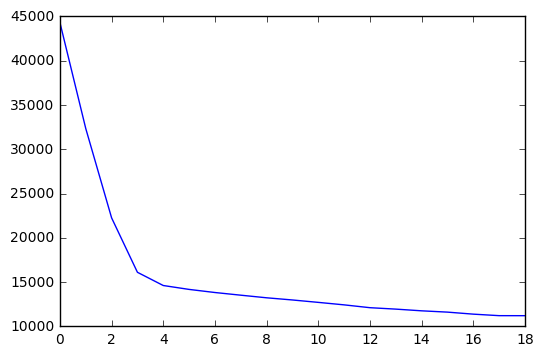

In [176]:
error_k = []
for k in range(1, 20):
    #print(k)

    model = AbstractModel()

    model.I = RangeSet(1, nsample)
    model.J = RangeSet(1, nvariables+1)

    model.B = Var(model.J, domain=Reals)
    model.A = Var(model.J, domain=Binary)

    model.t = Var(model.I, domain=NonNegativeReals)


    def obj_func(model):
        return sum(model.t[i] for i in model.I)
    model.OBJ = Objective(rule=obj_func, sense=minimize)

    def const1(model, i):
        return -(sum((model.B[j]*X[i-j, j-1]) for j in model.J)) - model.t[i] <= -Y[i-1]
    model.const1 = Constraint(model.I, rule=const1)

    def const2(model, i):
        return -(sum((model.B[j]*X[i-1, j-1]) for j in model.J)) + model.t[i] >= -Y[i-1]
    model.const2 = Constraint(model.I, rule=const2)

    def const3(model, i):
        return model.t[i] >= 0
    model.const3 = Constraint(model.I, rule=const3)

    def const4(model, j):
        return model.B[j] >= -M*model.A[j]
    model.const4 = Constraint(model.J, rule=const4)

    def const5(model, j):
        return model.B[j] <= M*model.A[j]
    model.const5 = Constraint(model.J, rule=const5)

    def const6(model):
        return sum(model.A[j] for j in model.J) <=k
    model.const6 = Constraint(rule=const6)
    
    instance = model.create_instance()
    results = opt.solve(instance)
    
    error_k.append(sum_error(instance))
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(error_k)
    
    
    

In [123]:
instance.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=500, Domain=Integers, Ordered=True, Bounds=(1, 500)
        Virtual
    J : Dim=0, Dimen=1, Size=21, Domain=Integers, Ordered=True, Bounds=(1, 21)
        Virtual

3 Var Declarations
    A : Size=21, Index=J
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :     1 : False : False : Binary
          2 :     0 :     0 :     1 : False : False : Binary
          3 :     0 :     0 :     1 : False : False : Binary
          4 :     0 :     0 :     1 : False : False : Binary
          5 :     0 :     1 :     1 : False : False : Binary
          6 :     0 :     1 :     1 : False : False : Binary
          7 :     0 :     0 :     1 : False : False : Binary
          8 :     0 :     0 :     1 : False : False : Binary
          9 :     0 :     0 :     1 : False : False : Binary
         10 :     0 :     1 :     1 : False : False : Binary
         11 :     0 :     0 :     1 : False : False : Binary
       

## Exercise 5

Another possibility to find β is the robust linear regression problem that exploits the robustness of the error median against outliers. It can be formulated as:

$$ \min_{\beta} \, median\, (|y_1-\beta ' x_1\, ..., |y_n - \beta ' x_n| ) $$

Formulate this model as a MILP and implement and solve it in Pyomo. Due to its computational complexity, consider as an input n=30 random observations (i=1,...,30), from a linear regression model with m=5 variables (j=1,...,5).

$$ \min_{t,\beta}\sum^n_{i=1} t_i $$
$$s.t. \, -t \leq y-X\beta \leq t$$
$$t \geq 0 $$

$$ A_j=
  \begin{cases}
    1       & \quad \text{if } \text{feature is used}\\
    0  & \quad \text{otherwise } \\
  \end{cases}
$$

$$\sum_{j=1}^m A_j \leq k$$
$$-MA_j \leq \beta_j$$
$$MA_j \geq \beta_j $$

$$ O_i=
  \begin{cases}
    1       & \quad \text{if } \text{observation i is an outlier}\\
    0  & \quad \text{otherwise } \\
  \end{cases}
$$

$$\sum_{i=1}^m O_i \leq \gamma$$
$$-t_i-MO_i \leq y_i - \beta X_i $$
$$t_i+MO_i \geq y_i - \beta X_i $$

In [177]:
nsample = 30
nvariables = 5
X0=np.ones([nsample, 1])
X1=np.random.uniform(0, 10, ([nsample,nvariables]))
X=np.concatenate([X0, X1], axis=1)
error=np.random.normal(0, 1, (nsample,1))
beta=np.random.uniform(-5, 5, size=([nvariables+1, 1]))
Y=np.dot(X, beta)+error

[[-0.08505943]
 [ 3.65424749]
 [ 2.6918367 ]
 [-2.95470646]
 [ 2.87793487]
 [-2.37138087]]


In [282]:
k=5
M=5

# max number of outliers
G=15

model = AbstractModel()


model.I = RangeSet(1, nsample)
model.J = RangeSet(1, nvariables+1)

model.B = Var(model.J, domain=Reals)
model.A = Var(model.J, domain=Binary)

model.O = Var(model.I, domain=Binary)
model.t = Var(model.I, domain=NonNegativeReals)


def obj_func(model):
    return sum(model.t[i] for i in model.I)
model.OBJ = Objective(rule=obj_func, sense=minimize)

def const1(model, i):
    return -(sum((model.B[j]*X[i-j, j-1]) for j in model.J)) - model.t[i] <= -Y[i-1]
model.const1 = Constraint(model.I, rule=const1)

def const2(model, i):
    return -(sum((model.B[j]*X[i-1, j-1]) for j in model.J)) + model.t[i] >= -Y[i-1]
model.const2 = Constraint(model.I, rule=const2)

def const3(model, i):
    return model.t[i] >= 0
model.const3 = Constraint(model.I, rule=const3)

def const4(model, j):
    return model.B[j] >= -M*model.A[j]
model.const4 = Constraint(model.J, rule=const4)

def const5(model, j):
    return model.B[j] <= M*model.A[j]
model.const5 = Constraint(model.J, rule=const5)

def const6(model):
    return sum(model.A[j] for j in model.J) <=k
model.const6 = Constraint(rule=const6)


def const7(model, i):
    M = 100000 #np.median(model.t)
    return -(sum((model.B[j]*X[i-j, j-1]) for j in model.J)) - model.t[i]+ M*model.O[i] <= -Y[i-1]
    #return -sum((model.B[j]*X[i-1, j-1]) for j in model.J) - model.t[i] - M*model.O[i] <= -Y[i-1]
    #return -model.t[i] - M* model.O[i] + sum((model.B[j]*X[i-1, j-1]) for j in model.J) <= Y[i-1]
    #return -model.t[i] - M* model.O[i] <= Y[i-1]- ((model.B[j]*X[i-1, j-1]) for j in model.J)
model.const7 = Constraint(model.I, rule=const7)

def const8(model, i):
    M = 100000 #np.median(model.t)
    return -(sum((model.B[j]*X[i-1, j-1]) for j in model.J)) + model.t[i]- M*model.O[i] >= -Y[i-1]
    #return -sum((model.B[j]*X[i-1, j-1]) for j in model.J) + model.t[i] + M* model.O[i] >= -Y[i-1]
    #return model.t[i] + M* model.O[i] + sum((model.B[j]*X[i-1, j-1]) for j in model.J) >= Y[i-1] 
    #return model.t[i] + M* model.O[i] >= Y[i-1]- ((model.B[j]*X[i-1, j-1]) for j in model.J)
model.const8 = Constraint(model.I, rule=const8)

def const9(model):
    return sum(model.O[i] for i in model.I) <= G
model.const9 = Constraint(rule=const9)




In [283]:
instance = model.create_instance()
results = opt.solve(instance)
print(results)


Problem: 
- Lower bound: 349.4144696
  Upper bound: 349.4144696
  Number of objectives: 1
  Number of constraints: 165
  Number of variables: 73
  Number of nonzeros: 991
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0124559402466
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [284]:
instance.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=30, Domain=Integers, Ordered=True, Bounds=(1, 30)
        Virtual
    J : Dim=0, Dimen=1, Size=6, Domain=Integers, Ordered=True, Bounds=(1, 6)
        Virtual

4 Var Declarations
    A : Size=6, Index=J
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     0 :     1 : False : False : Binary
          2 :     0 :     1 :     1 : False : False : Binary
          3 :     0 :     1 :     1 : False : False : Binary
          4 :     0 :     1 :     1 : False : False : Binary
          5 :     0 :     1 :     1 : False : False : Binary
          6 :     0 :     1 :     1 : False : False : Binary
    B : Size=6, Index=J
        Key : Lower : Value    : Upper : Fixed : Stale : Domain
          1 :  None :        0 :  None : False : False :  Reals
          2 :  None :  3.73451 :  None : False : False :  Reals
          3 :  None :  2.90427 :  None : False : False :  Reals
          4 :  None : -3.31108 :  Non